In [582]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.ndimage import gaussian_filter

In [583]:

def visualize(arr: np.array, cmap: str = "viridis", flip: bool = False):
    img = np.copy(arr)
    img = img - img.min()
    img = img / img.max()
    plt.imshow(img, cmap=cmap, origin="upper")


def magnitude2(arrX: np.array, arrY: np.array):
    return np.sqrt(arrX**2 + arrY**2)


def interp2d(a, x, y):
    X = np.floor(x).astype(int)
    Y = np.floor(y).astype(int)
    fracX = x - X
    fracY = y - Y
    X = min(max(X, 0), a.shape[0] - 2)
    Y = min(max(Y, 0), a.shape[1] - 2)

    U1 = (1.0 - fracX) * a[X + 0, Y + 0] + fracX * a[X + 1, Y + 0]
    U2 = (1.0 - fracX) * a[X + 0, Y + 1] + fracX * a[X + 1, Y + 1]
    U = (1.0 - fracY) * U1 + fracY * U2
    return U


def diff2(a, x, y):
    h = 1.0
    dadx = (interp2d(a, x + h, y) - interp2d(a, x - h, y)) / (2 * h)
    dady = (interp2d(a, x, y + h) - interp2d(a, x, y - h)) / (2 * h)
    return dadx, dady

In [584]:
d1 = h5py.File("../isabel_2d.h5", "r")
u = np.array(d1["Velocity"]["X-comp"])
v = np.array(d1["Velocity"]["Y-comp"])
# u, v = v.T,
img = np.array([u, v, np.zeros_like(u)])

mesh_size = u.shape[0]
dudx, dudy = np.gradient(u, axis=(0, 1))
dvdx, dvdy = np.gradient(v, axis=(0, 1))

In [585]:
eps = 0.3
a, b, c, d = dudx, dudy, dvdx, dvdy

# Compute eigenvalues
p = (a + d).astype(complex)
q = (a * d - b * c).astype(complex)
discriminant = np.sqrt(p**2 - 4 * q)
lambda_1 = 0.5 * (p + discriminant)
lambda_2 = 0.5 * (p - discriminant)

real_lambda_1 = np.real(lambda_1)
real_lambda_2 = np.real(lambda_2)
imag_lambda_1 = np.imag(lambda_1)

saddle_mask = ((real_lambda_1 < 0) & (real_lambda_2 > 0)) | ((real_lambda_2 < 0) & (real_lambda_1 > 0)) 
sink_mask = (real_lambda_1 < 0) & (real_lambda_2 < 0) & (imag_lambda_1 == 0)
source_mask = (real_lambda_1 > 0) & (real_lambda_2 > 0) & (imag_lambda_1 == 0)
stable_spiral_mask = (real_lambda_1 < 0) & (imag_lambda_1 != 0)
unstable_spiral_mask = (real_lambda_1 > 0) & (imag_lambda_1 != 0)
center_mask = (real_lambda_1 == 0) & (imag_lambda_1 != 0)   
degenerate_mask = (lambda_1 == lambda_2)

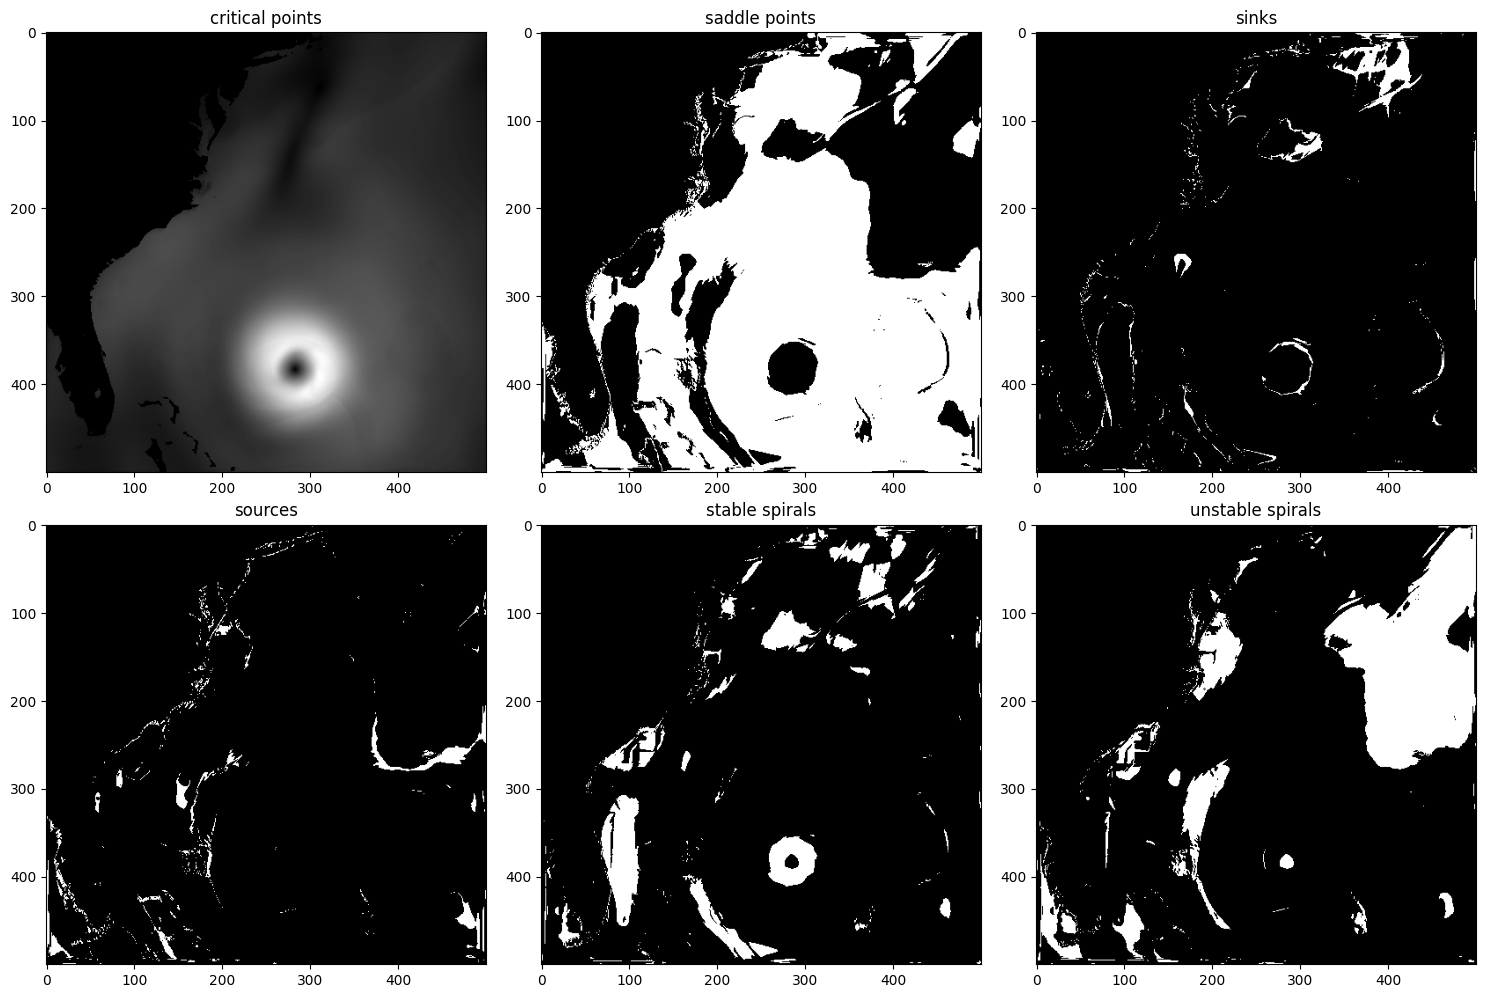

In [586]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
plt.set_cmap('grey')
axs[0, 0].imshow(magnitude2(u, v))
axs[0, 0].set_title("critical points")
axs[0, 1].imshow(saddle_mask)
axs[0, 1].set_title("saddle points")
axs[0, 2].imshow(sink_mask)
axs[0, 2].set_title("sinks")
axs[1, 0].imshow(source_mask)
axs[1, 0].set_title("sources")
axs[1, 1].imshow(stable_spiral_mask)
axs[1, 1].set_title("stable spirals")
axs[1, 2].imshow(unstable_spiral_mask)
axs[1, 2].set_title("unstable spirals")
plt.tight_layout()
plt.show()

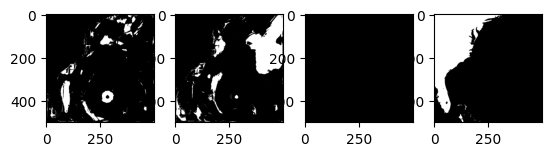

In [587]:
plt.subplots(1, 4)
plt.subplot(1, 4, 1)
plt.imshow(stable_spiral_mask)
plt.subplot(1, 4, 2)
plt.imshow(unstable_spiral_mask)
plt.subplot(1, 4, 3)
plt.imshow(center_mask)
plt.subplot(1, 4, 4)
plt.imshow(degenerate_mask)

In [588]:
num_particles = 500
T = 100
dt = 0.5
h = dt
steps = int(T / dt)
method = "rk4"

trajectories = []
lines = []
seeds_x = []
seeds_y = []

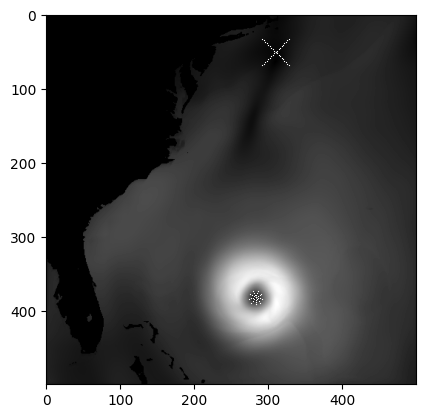

In [589]:
# finish generating seeds based on topology
critical_points_x = [382, 50]
critical_points_y = [283, 310]
plt.imshow(magnitude2(u, v))

n_angles = 10
angles = np.linspace(0, 2*np.pi, 10)
spiral_k = 4
spiral_d = 3.0
saddle_k = 10
saddle_d = 2.0

for (x, y) in zip(critical_points_x, critical_points_y):
    tick = 'r*'
    if (saddle_mask[x, y]):
        # tick = 'b*'
        seeds_x.append(x)
        seeds_y.append(y)
        for i in range(saddle_k):
            seeds_x.append(x+i*saddle_d)
            seeds_y.append(y+i*saddle_d)

            seeds_x.append(x+i*saddle_d)
            seeds_y.append(y-i*saddle_d)

            seeds_x.append(x-i*saddle_d)
            seeds_y.append(y+i*saddle_d)

            seeds_x.append(x-i*saddle_d)
            seeds_y.append(y-i*saddle_d)
        
    if (stable_spiral_mask[x, y] or unstable_spiral_mask[x, y]):
        plt.plot(y, x)
        for angle in angles:
            for i in range(spiral_k):
                r = i*spiral_d
                seeds_x.append(x+r*np.cos(angle))
                seeds_y.append(y+r*np.sin(angle))
plt.plot(seeds_y, seeds_x, 'w*', markersize=0.3)


In [590]:
print(len(trajectories))
for i in range(len(seeds_x)):
    pos_x, pos_y = seeds_x[i], seeds_y[i]
    trajectory_x = [pos_x]
    trajectory_y = [pos_y]

    for j in range(steps):
        out_of_bounds = (
            (pos_x < 0)
            or (pos_y < 0)
            or (pos_x >= u.shape[0] - 2)
            or (pos_y >= u.shape[1] - 2)
        )
        if out_of_bounds:
            break
        if method == "euler":
            tmp_x = pos_x

            pos_x += interp2d(u, pos_x, pos_y) * dt
            pos_y += interp2d(v, tmp_x, pos_y) * dt

        elif method == "rk4":
            x0, y0 = pos_x, pos_y
            k0x, k0y = interp2d(u, x0, y0), interp2d(v, x0, y0)
            x1 = x0 + 0.5 * h * k0x
            y1 = y0 + 0.5 * h * k0y
            k1x, k1y = interp2d(u, x1, y1), interp2d(v, x1, y1)
            x2 = x0 + 0.5 * h * k1x
            y2 = y0 + 0.5 * h * k1y
            k2x, k2y = interp2d(u, x2, y2), interp2d(v, x2, y2)
            x3 = x0 + h * k2x
            y3 = y0 + h * k2y
            k3x, k3y = interp2d(u, x3, y3), interp2d(v, x3, y3)
            pos_x = x0 + (h / 6) * (k0x + 2 * k1x + 2 * k2x + k3x)
            pos_y = y0 + (h / 6) * (k0y + 2 * k1y + 2 * k2y + k3y)
            

        trajectory_x.append(pos_x)
        trajectory_y.append(pos_y)

    trajectories.append((trajectory_x, trajectory_y))

0


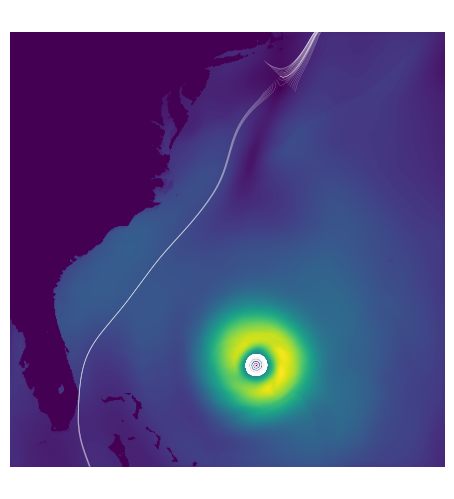

In [591]:
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.axis('off')
visualize(magnitude2(u, v))
for traj in trajectories:
    plt.plot(traj[1], traj[0], 'w', linewidth=0.1)

plt.show()